# Kaggle Final Project

## Imports

In [33]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier

# Other Imports
import gdown
from xgboost import XGBClassifier

## Loading the data

In [34]:
# Install gdown if not present
# !pip3 install -U -qq --no-cache-dir gdown --pre

In [36]:
url = "https://drive.google.com/uc?id=1_FZIrNug8svcEK5QMDdV2MoHmcCny8kJ&export=download"
output = "train.csv"
gdown.download(url, output)

url = "https://drive.google.com/uc?id=1_FAidr3sAiSWx6mPS26HMpWjVaiSTOXq&export=download"
output = "test.csv"
gdown.download(url, output)

df_hc = pd.read_csv('./train.csv', index_col=0)
df_hc.head()

  7%|▋         | 92.8M/1.24G [00:50<06:55, 2.76MB/s]

In [6]:
# Creating a copy to avoid reloading again
df_hcc = df_hc.copy()

## EDA and Preprocessing

<b><i>Data Description</b></i>: <br>
This is a classification problem to distinguish between a signal process which produces supersymmetric particles and a background process which does not.

The data has been produced using Monte Carlo simulations. The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes.

Let us first look at class balance in the data (If imbalanced we might need stratified sampling).

<AxesSubplot:>

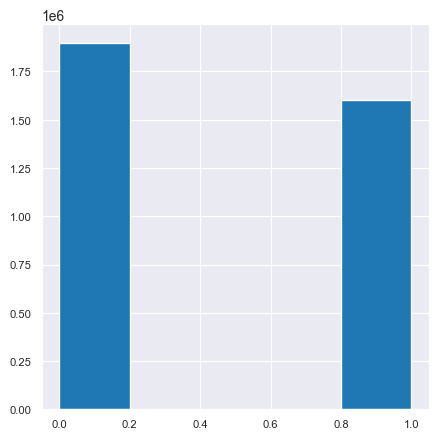

In [7]:
df_hcc[df_hcc.columns[18]].hist(figsize=(5, 5), bins=5, xlabelsize=8, ylabelsize=8)

<b><i>Analysis:</i></b> <br>
Classes seem to be roughly equal. Hence, we can directly perform train_test_split.

In [8]:
# Check for NaN values
df_hcc.isna().sum()

lepton_1_pT                 0
lepton_1_eta                0
lepton_1_phi                0
lepton_2_pT                 0
lepton_2_eta                0
lepton_2_phi                0
missing_energy_magnitude    0
missing_energy_phi          0
MET_rel                     0
axial_MET                   0
M_R                         0
M_TR_2                      0
R                           0
MT2                         0
S_R                         0
M_Delta_R                   0
dPhi_r_b                    0
cos(theta_r1)               0
class                       0
dtype: int64

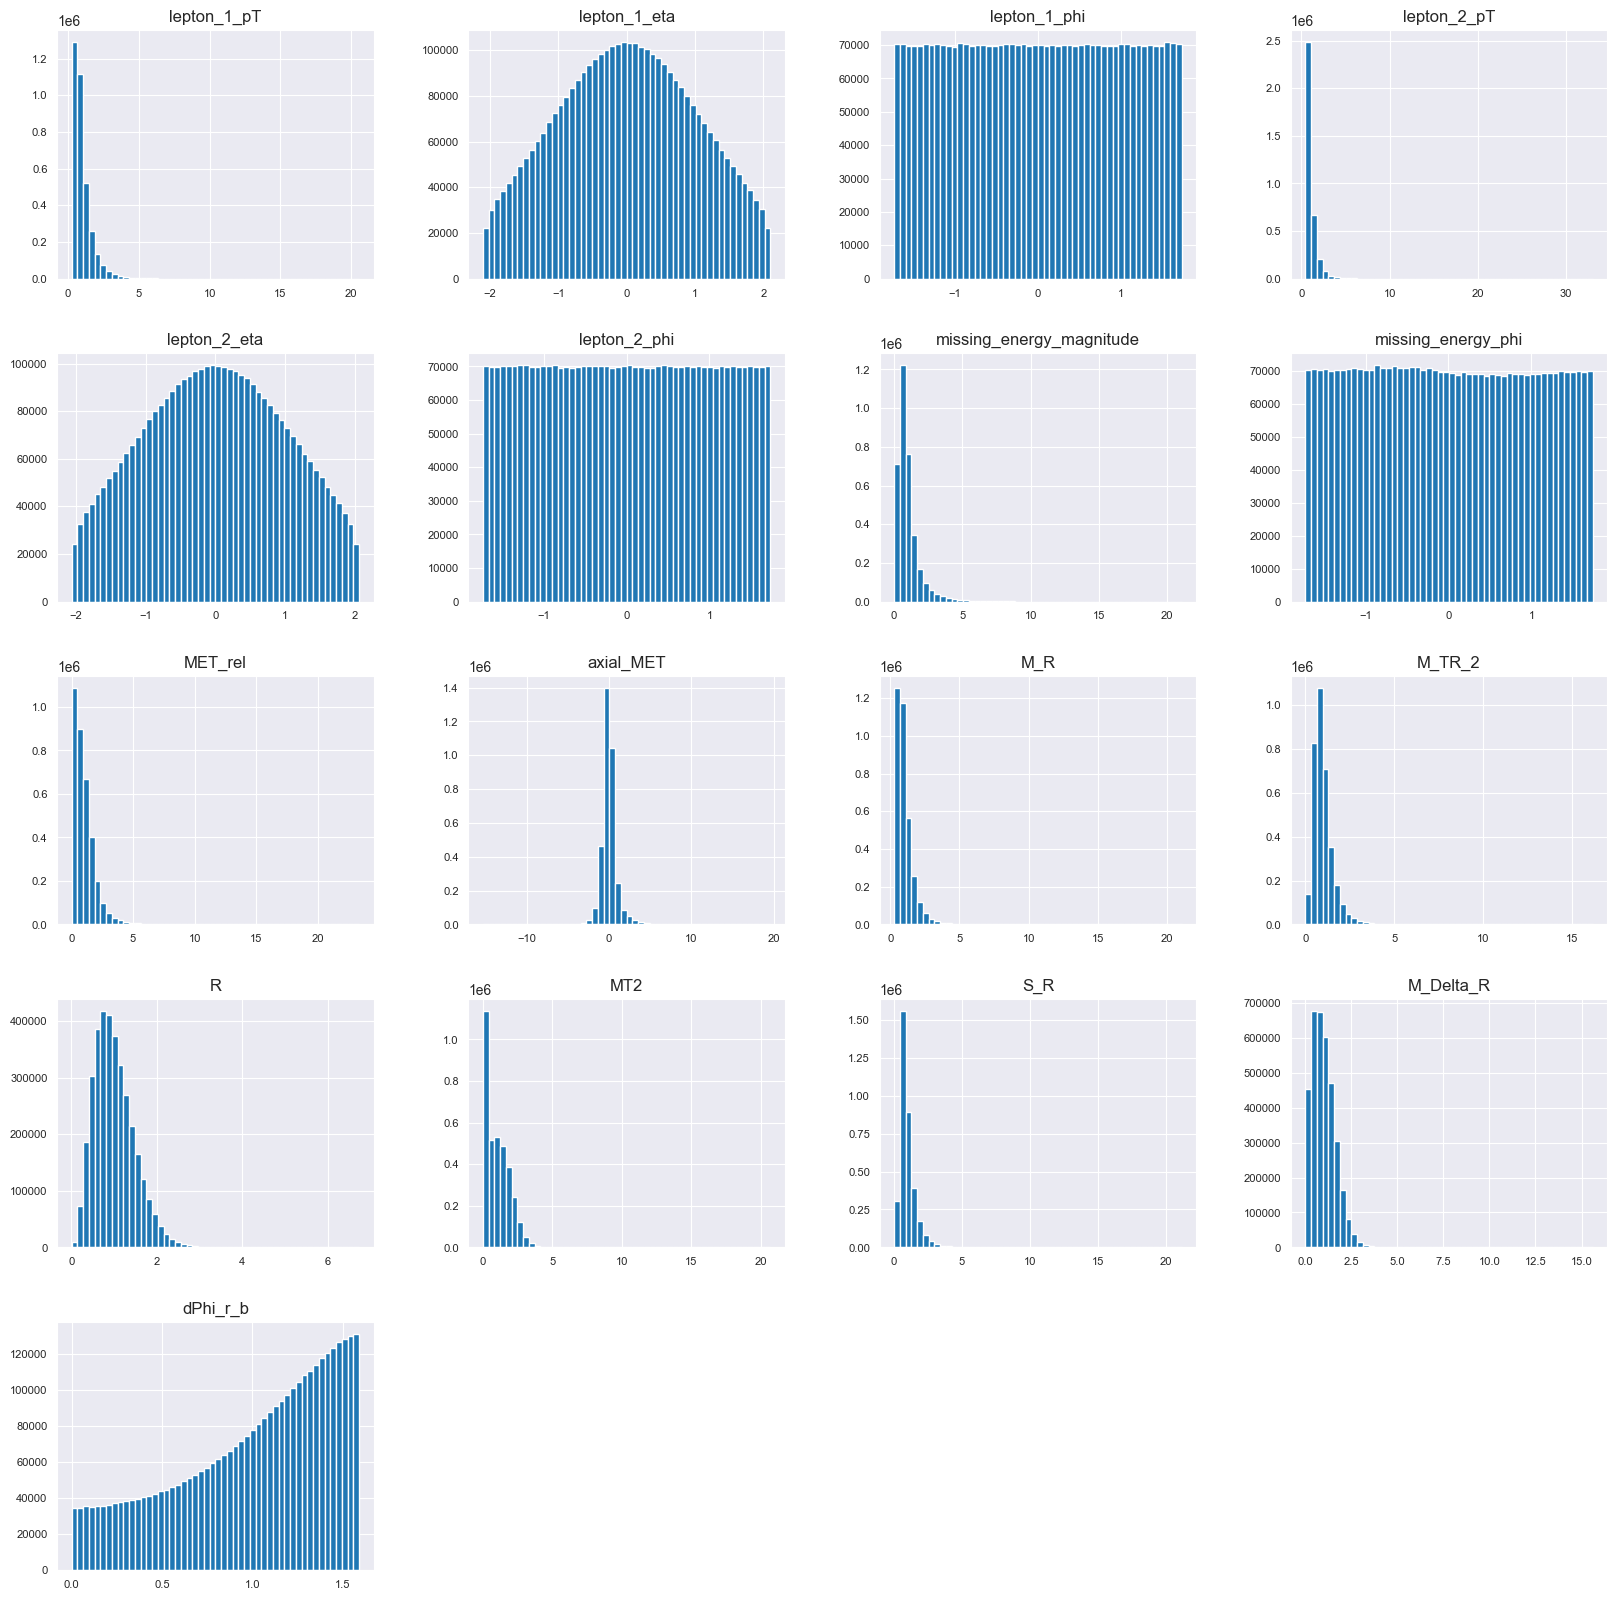

In [9]:
# Check the distribution of data
df_hcc[df_hcc.columns[:17]].hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)
pass

<b><i>Analysis:</i></b> <br>
Some of the data is skewed to one side. We can use log transformation to make it normally distributed so that patterns are easily identifiable.

In [10]:
# Columns ['M_TR_2', 'R', 'S_R', 'M_Delta_R'] can be log transformed to give a normal ditribution.
df_hcc.iloc[:,[11,12,14,15]] = df_hcc.iloc[:,[11,12,14,15]].apply(lambda x:np.log(x))

# MT2 column has many zero values so log transform cannot be applied. Hence, using sdquare root transform.
print('MT2 zeros count:', (df_hcc['MT2'] ==0).sum())
df_hcc.iloc[:,[13]] = df_hcc.iloc[:,[13]].apply(lambda x:np.sqrt(x))

MT2 zeros count: 743164


<AxesSubplot:>

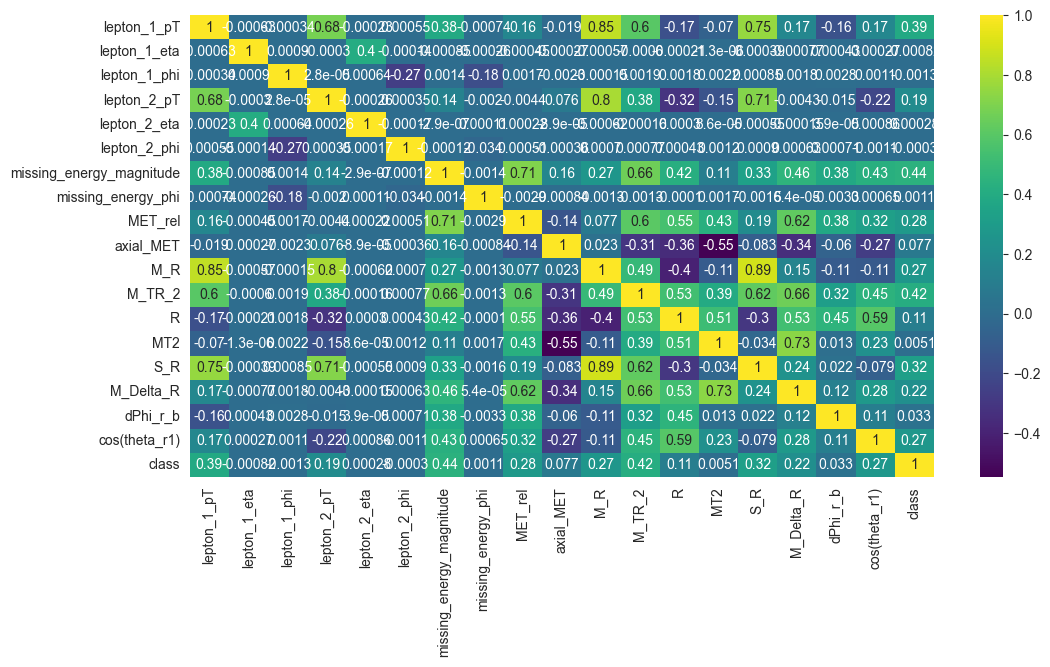

In [11]:
# Check the correlation matrix
plt.figure(figsize=(12,6))
sns.heatmap(df_hcc.corr(), cmap='viridis', annot=True)

<AxesSubplot:xlabel='class', ylabel='lepton_2_pT'>

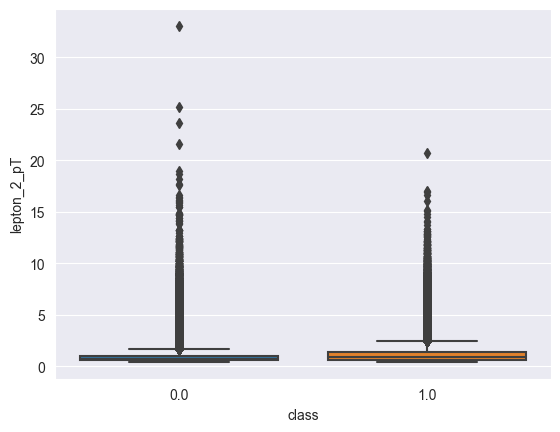

In [12]:
# Check boxplots for any outliers
sns.boxplot(data=df_hcc, y='lepton_2_pT', x='class')

<b><i>Analysis:</i></b> <br>
There appear to be a few extreme outlier data points that are may be creating distortions in the data. These can be removed as we are still left with a large dataset to train on.

In [13]:
df_hcc=df_hcc[df_hcc['lepton_1_pT'] < 5]

In [14]:
# Dropping these columns based on their low values of feature_importances_ calculated from the RandomForest model trained which is further in the notebook.
df_hcc = df_hcc.drop(columns =['lepton_1_phi', 'missing_energy_phi', 'lepton_2_phi'], axis=1)

## Splitting and Scaling

In [15]:
# Split the data in the ratio of 60:40 for training.
X = df_hcc.loc[:,df_hcc.columns != 'class'].to_numpy(dtype=np.float_)
y = df_hcc['class'].to_numpy(dtype=np.float_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [16]:
# Applying StandardScaler since most of the features follow normal distribution.
scaler_train_test = StandardScaler()               # This scaler is for the train test split and hyperparameter tuning.
X_train = scaler_train_test.fit_transform(X_train)
X_test = scaler_train_test.transform(X_test)

scaler_full = StandardScaler()                     # This scaler is for the entire data and final training.
X = scaler_full.fit_transform(X)

## Applying Models

Models like SVM Classifier will be too difficult to train on this data since there would be a million Langrangian variables for the solver which will make the closed form solution extremely slow. Hence, we need go for other models like Tree Based Models, LinearSVM (optimized for large data) and SGDClassifiers, or Bayesian Models.

#### SGDClassifier

In [17]:
# param_grid = {
#     'loss' : ['hinge', 'log_loss', 'log', 'modified_huber'],# 'squared_hinge'],# 'perceptron'],
#     'random_state': [42],
#     'penalty': ['elasticnet'],
#     'l1_ratio': [0.2],# 0.4],
#     'alpha': [0.001, 0.01, 0.1, 1, 10],
#     }

# model_grid_svm = GridSearchCV(SGDClassifier(n_jobs=-1), param_grid=param_grid,
#                                  n_jobs=-1, cv=5, verbose=2)
# model_grid_svm.fit(X_train, y_train)

# print('Best Params:', model_grid_svm.best_params_)
# print('Accuracy:',model_grid_svm.score(X_test, y_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'alpha': 0.001, 'l1_ratio': 0.2, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'random_state': 42}
Accuracy: 0.789077715784891


In [18]:
# model_sgd = SGDClassifier(loss=model_grid_svm.best_params_['loss'],
#             penalty='elasticnet', l1_ratio=0.2, random_state=42, alpha=model_grid_svm.best_params_['alpha'])
# model_sgd.fit(X, y)
# print('Training Accuracy:', model_sgd.score(X, y))

Training Accuracy: 0.7888076488827812


#### Naive Bayes Classifier

In [19]:
# from sklearn.naive_bayes import GaussianNB
# params_NB = {'var_smoothing': np.logspace(0,-9, num=20)}
# gs_NB = GridSearchCV(estimator=GaussianNB(), 
#                  param_grid=params_NB, 
#                  cv=5,
#                  n_jobs=-1,
#                  verbose=1, 
#                  scoring='accuracy') 
# gs_NB.fit(X_train, y_train)


# print('Best Params:', gs_NB.best_params_)
# print('Accuracy:', gs_NB.score(X_test, y_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'var_smoothing': 5.455594781168526e-05}
Accuracy: 0.7458025914808789


In [20]:
# model_nb = GaussianNB(var_smoothing=gs_NB.best_params_['var_smoothing'])
# model_nb.fit(X, y)
# print('Training Accuracy:', model_nb.score(X, y))

Training Accuracy: 0.7452571118261301


#### Random Forest Classifier

Random Forest is suitable for situations when we have a large dataset, and interpretability is not a major concern. Since, the dataset contains simulation data for particle accelerator and interpretatbility is not an issue here, we can go for ensemble models like RandomForest.

In [23]:
# params_rf = {'n_estimators': [120, 140, 160, 180, 200]}
# model_rf = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=params_rf, cv=5, n_jobs=-1)

# model_rf.fit(X_train ,y_train)
# print('Best Params:', model_rf.best_params_)
# print('Accuracy:', model_rf.score(X_test, y_test))

Best Params: {'n_estimators': 160}
Accuracy: 0.8000015752812593


In [33]:
# pd.DataFrame([df_hcc.columns[:-1], model_rf.feature_importances_]).T.sort_values(by=1)

,0,1
10,MT2,0.03887
9,R,0.043661
2,lepton_2_pT,0.04432
13,dPhi_r_b,0.047058
12,M_Delta_R,0.047714
3,lepton_2_eta,0.048711
1,lepton_1_eta,0.053247
14,cos(theta_r1),0.055755
11,S_R,0.056085
5,MET_rel,0.060338


In [ ]:
# model_rf = RandomForestClassifier(n_estimators=160)
# model_rf.fit(X_train, y_train)
# model_rf.score(X_test, y_test)
# model_rf.fit(X, y)
# print('Training Accuracy:', model_rf.score(X, y))

#### AdaBoost Classifier

In [34]:
# model_ada = AdaBoostClassifier(n_estimators=150, learning_rate=0.1)
# model_ada.fit(X_train, y_train)
# model_ada.score(X_test, y_test)

## Takes too loing to train

#### Gradient Boost Models

Gradient Bosting models work well when there is a large amount of data and the number of features is less. Here, I will be trying 2 different types of Gradient Boosting models - sklearn HistGradientBoostingClassifier and xgboost XGBClassifier

<b>Histogram Gradient Boosting Classifier</b>

In [19]:
# param_grid = {
#     'learning_rate': (0.01, 0.05, 0.1, 0.5, 1),
#     'random_state': [42],
#     'max_iter': [500, 1000],
#     'max_leaf_nodes': (200, 500, 1000),
#     'l2_regularization': (0.5, 1.0, 2.0)}

# gs_hgbc = RandomizedSearchCV(HistGradientBoostingClassifier(), param_distributions=param_grid,
#                                  n_jobs=-1, cv=5, verbose=2)
# gs_hgbc.fit(X_train, y_train)

# print('Best Params:', gs_hgbc.best_params_)
# print('Accuracy:', gs_hgbc.score(X_test, y_test))

C:\Users\kishl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [27]:
# model_xg = HistGradientBoostingClassifier(l2_regularization=gs_hgbc.best_params_['l2_regularization'],
#                                 learning_rate=gs_hgbc.best_params_['learning_rate'],
#                                 max_leaf_nodes=gs_hgbc.best_params_['max_leaf_nodes'],
#                                 max_iter=gs_hgbc.best_params_['max_iter'], random_state=42)

# model_xg = HistGradientBoostingClassifier(l2_regularization=2, max_leaf_nodes=1000, max_iter=1000, learning_rate=0.03, random_state=42)
# model_xg.fit(X_train, y_train)
# model_xg.score(X_test, y_test)
# model_xg.fit(X, y)
# print('Training Accuracy:', model_xg.score(X, y))

Training Accuracy: 0.812210899921465


Final Predictions

In [31]:
# X_t = pd.read_csv('./test.csv', index_col=0)            

# X_t.iloc[:,[11,12,14,15]] = X_t.iloc[:,[11,12,14,15]].apply(lambda x:np.log(x))
# X_t.iloc[:,[13]] = X_t.iloc[:,[13]].apply(lambda x:np.sqrt(x))

# X_t = X_t.drop(columns=['lepton_1_phi', 'missing_energy_phi', 'lepton_2_phi'], axis=1)
# X_t = X_t.to_numpy(dtype=np.float_)

# X_t = scaler_full.transform(X_t)

# output_xg = pd.Series(model_xg.predict(X_t).astype(np.float_), name='class')
# output_xg.to_csv('res_xg.csv', index=True, index_label='Id')

<b>XGB Classifier</b>

In [19]:
# params = { 'max_depth': [10,25,30],
#            'learning_rate': [0.01, 0.1, 1],
#            'subsample': np.linspace(0,1,10),
#            'colsample_bytree': np.linspace(0,1,5),
#            'colsample_bylevel': np.linspace(0,1,5),
#           'min_child_weight':[10, 20, 30],
#          'gamma':np.linspace(0, 0.1, 10),
#           'n_estimators': [300, 500, 700, 900],
#          }
# gs_xgb = RandomizedSearchCV(XGBClassifier(), param_distributions=params, cv=5, verbose=1)
# gs_xgb.fit(X_train, y_train)
# gs_xgb.score(X_test, y_test)

In [20]:
# model_xgb = XGBClassifier(max_depth=gs_xgb.best_params_['max_depth'], learning_rate=gs_xgb.best_params_['learning_rate'],
#  subsample=gs_xgb.best_params_['subsample'], colsample_bytree=gs_xgb.best_params_['colsample_bytree'],
#  colsample_bylevel=gs_xgb.best_params_['colsample_bytree'], min_child_weight=gs_xgb.best_params_['min_child_weight'],
#  gamma=gs_xgb.best_params_['gamma'], num_parallel_tree=4,
#  objective='binary:logistic', eval_metric='merror', tree_method='hist',
#  n_estimators=gs_xgb.best_params_['n_estimators'], random_state=42, n_jobs=-1)

model_xgb = XGBClassifier(max_depth=10, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8,
 colsample_bylevel=0.8, min_child_weight=13, gamma=0.09, num_parallel_tree=4,
 objective='binary:logistic', eval_metric='merror', tree_method='hist', n_estimators=900, random_state=42, n_jobs=-1)

model_xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', feature_types=None, gamma=0.09, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=10, max_leaves=0, min_child_weight=13, missing=nan,
              monotone_constraints='()', n_estimators=900, n_jobs=-1,
              num_parallel_tree=4, predictor='auto', random_state=42, ...)

Final Predictions

In [32]:
X_t = pd.read_csv('./test.csv', index_col=0)

X_t.iloc[:,[11,12,14,15]] = X_t.iloc[:,[11,12,14,15]].apply(lambda x:np.log(x))
X_t.iloc[:,[13]] = X_t.iloc[:,[13]].apply(lambda x:np.sqrt(x))

X_t = X_t.drop(columns=['lepton_1_phi', 'missing_energy_phi', 'lepton_2_phi'], axis=1)
X_t = X_t.to_numpy(dtype=np.float_)

X_t = scaler_full.transform(X_t)

output_xgb = pd.Series(model_xgb.predict(X_t).astype(np.float_), name='class')
output_xgb.to_csv('res_xgb.csv', index=True, index_label='Id')

#### Voting Classifier

In [30]:
# model_vc = VotingClassifier([('hgbc', model_xg), ('xgb', model_xgb)]
#                             , voting='soft')
# model_vc.fit(X_train, y_train)
# model_vc.score(X_test, y_test)

0.8038474096647802

<b><i>Analysis:</i></b> <br>
Since, XGBoost gives the best result so we select it as the final model.